# Bank Marketing Campaign Prediction

## About the project 

Using data from a Portuguese banking institution, this project analyzes and predicts client subscriptions to bank term deposits. [The dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing) consists of phone-based direct marketing campaigns designed to predict if a customer will subscribe to a term deposit.
The project will go through three steps:

    Data Preprocessing 
    Exploratory Data Analysis (EDA)
    Model Building and Evaluation
    

### 1. Data Exploration and Preprocessing 

Starting by Loading Data 'bank-full.csv'


In [45]:
#This cel will be used to import needed packages bare in mind that you need to check if you got the same versions as I do, 
#I did put all the versions in packages.txt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#Evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix



In [3]:
data = pd.read_csv('bank-full.csv', delimiter= ';')

data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
# First of all we need to check the types of data on the data dataframe then the missing values

data.info()
data.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

As you can see there are no missing values on this dataset, if there was any, we would either drop them or replace them with mean or median depends on the situation 

Also we can check for any obvious anomalies by describing the dataset

In [5]:
data.describe().round(0)

,age,balance,day,duration,campaign,pdays,previous
count,45211.0,45211.0,45211.0,45211.0,45211.0,45211.0,45211.0
mean,41.0,1362.0,16.0,258.0,3.0,40.0,1.0
std,11.0,3045.0,8.0,258.0,3.0,100.0,2.0
min,18.0,-8019.0,1.0,0.0,1.0,-1.0,0.0
25%,33.0,72.0,8.0,103.0,1.0,-1.0,0.0
50%,39.0,448.0,16.0,180.0,2.0,-1.0,0.0
75%,48.0,1428.0,21.0,319.0,3.0,-1.0,0.0
max,95.0,102127.0,31.0,4918.0,63.0,871.0,275.0


Before moving on with the remaining data cleaning and transformations, there are some key insights we should extract from the data.describe() table:

The average balance is $1362.27, but note that balance values can be negative due to the fact that min is -8019, meaning some clients have an overdraft. Also blance has a wide range, from significant overdrafts to high positive balances. There are likely outliers that could be cleaned or handled during analysis.

Duration column has contacts lasting from 0 to very long calls, where calls with 0 duration might be failed attempts. and the Max is 4918 seconds compared to the mean of 258.16 means the possibility of another feature with outliers

pdays column shows that many clients were not contacted recently, with -1 being an indicator of no prior contact, while the average is high, indicating longer periods between contacts for some clients.

when it comes term deposit age is also important we have an average of 40.93 and a moderate standard deviation of 10.6, also 50% of the clients are above 39

before we proceed I need to  check some boxplots on both banlace, duration and age 


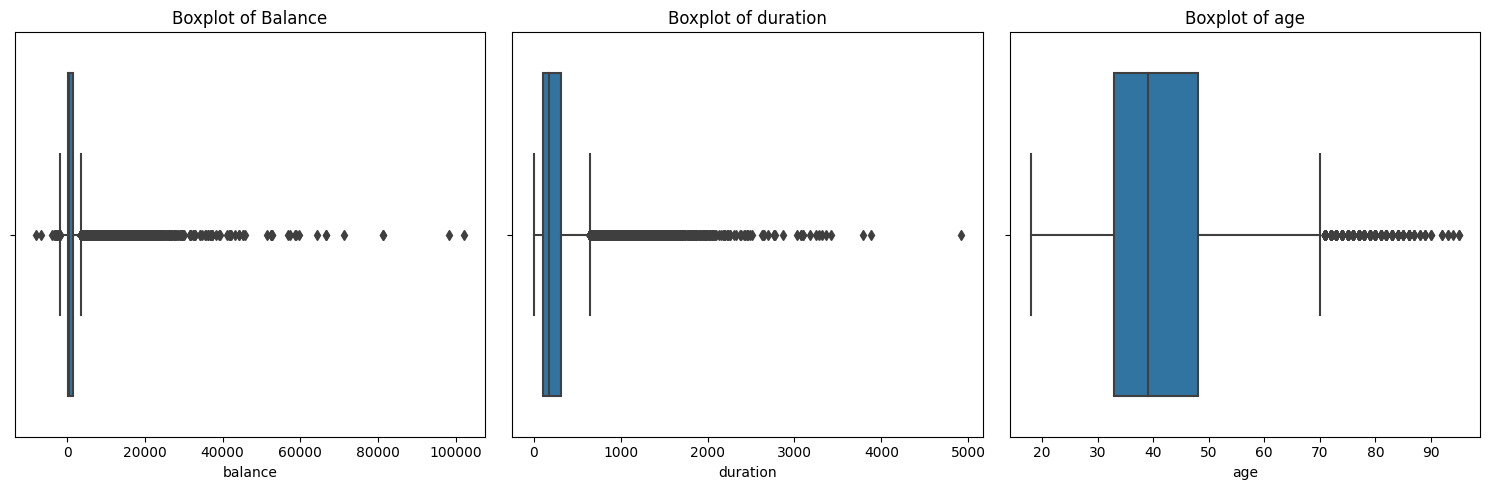

In [6]:
#box plot for the three colmuns

plt.figure(figsize= (15, 5))

#balance
plt.subplot(1, 3, 1)
sns.boxplot(data= data, x='balance')
plt.title('Boxplot of Balance')

#duration
plt.subplot(1, 3, 2)
sns.boxplot(data= data, x='duration')
plt.title('Boxplot of duration')

#age 
plt.subplot(1, 3, 3)
sns.boxplot(data= data, x='age')
plt.title('Boxplot of age')

plt.tight_layout()
plt.show()

As discussed based on the data.describe() results and the boxplots for balance, duration, and age, it's clear that outliers are present (all three columns are right-skewed). Whether or not to remove these outliers will depend on their impact on the performance of our logistic regression model. 

It's crucial to address outliers in any analysis, as they can distort the results. For this case, we'll proceed by building two versions of the model: one with the original data and another after handling the outliers. We will then compare the performance of each to assess the impact.

Outliers can sometimes contain important information but for both versions we will delete outliers for the duration column A value of 4918 seconds (around 82 minutes) for a phone call seems unrealistic in most marketing campaigns, especially for a task like subscribing to a term deposit.

### Capping outliers

We calculate the IQR(Iterquartile Range) then we define lower and upper bounds to filter out outliers. A common method is to multiply IQR by 1.5


In [7]:
q1 = data['duration'].quantile(0.25)  # 25th percentile
q3 = data['duration'].quantile(0.75)  # 75th percentile

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr


data['duration_clipped'] = data['duration'].clip(lower=lower_bound, upper=upper_bound)



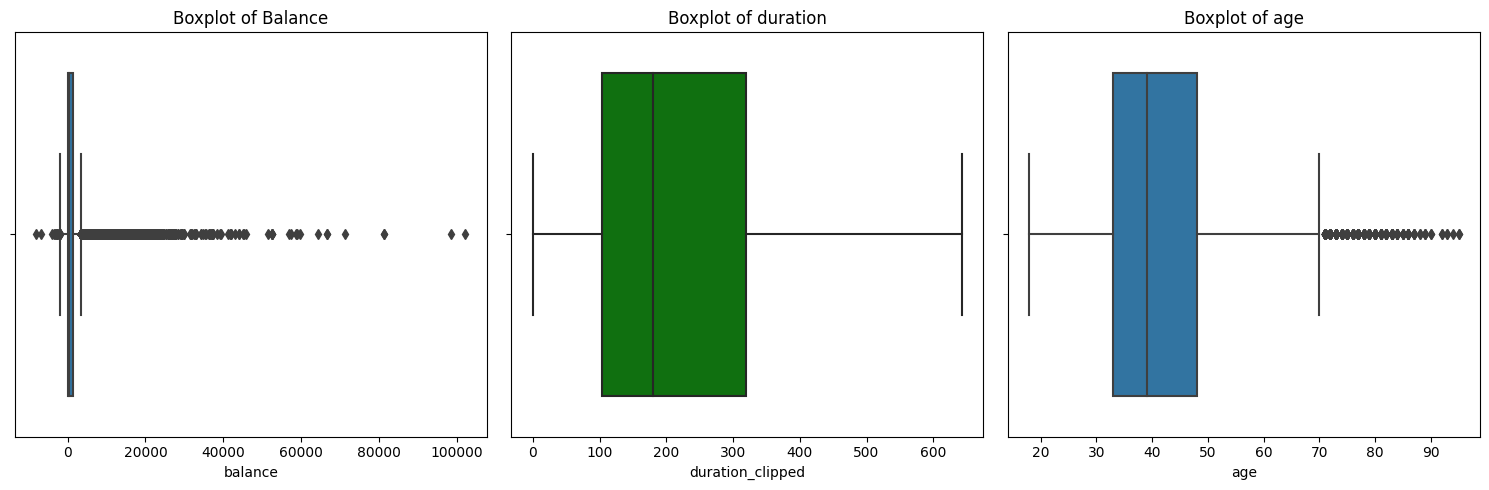

In [8]:
#box plot for the three colmuns

plt.figure(figsize= (15, 5))

#balance
plt.subplot(1, 3, 1)
sns.boxplot(data= data, x='balance')
plt.title('Boxplot of Balance')

#duration_clipped
plt.subplot(1, 3, 2)
sns.boxplot(data= data, x='duration_clipped', color= 'green')
plt.title('Boxplot of duration')

#age 
plt.subplot(1, 3, 3)
sns.boxplot(data= data, x='age')
plt.title('Boxplot of age')

plt.tight_layout()
plt.show()

After we capped duration column the new column 'duration_clipped' will be used for the rest 

Now we check if there are any duplicates on this dataset

### Checking and removing duplicates 


In [9]:
data.duplicated().sum()

0

Since there no duplicates we move to the rest 

Based on the dataset and the data.info() there some handling and transformation that needs to be done:

The pdays column has a value of -1 means the client was not contacted previously, for this one its better to create a binary feature to prepare it for the model 

The column 'y' (the target) will also be transformed to binary format (1 for 'yes' means subscribed to term deposit and 0 for 'no')

Column that has the same answer like 'default', 'housing', and 'loan' will also be transformed to binary format

We apply One-Hot Encoding to categorical columns that have more than two categories: 'job', 'marital', 'education', 'contact', 'month', 'day_of_week', and 'poutcome'

In [10]:
data['default'].unique()


array(['no', 'yes'], dtype=object)

In [11]:
data['housing'].unique()

array(['yes', 'no'], dtype=object)

In [12]:
data['loan'].unique()

array(['no', 'yes'], dtype=object)

In [13]:
data['y'].unique()

array(['no', 'yes'], dtype=object)

In [14]:
#pdays
data['pdays'] = data['pdays'].apply(lambda x: 0 if x == -1 else 1)
#target y
data['y'] = data['y'].apply(lambda x: 1 if x == 'yes' else 0)

data['default'] = data['default'].apply(lambda x: 1 if x == 'yes' else 0)
data['housing'] = data['housing'].apply(lambda x: 1 if x == 'yes' else 0)
data['loan'] = data['loan'].apply(lambda x: 1 if x == 'yes' else 0)

In [15]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,duration_clipped
0,58,management,married,tertiary,0,2143,1,0,unknown,5,may,261,1,0,0,unknown,0,261
1,44,technician,single,secondary,0,29,1,0,unknown,5,may,151,1,0,0,unknown,0,151
2,33,entrepreneur,married,secondary,0,2,1,1,unknown,5,may,76,1,0,0,unknown,0,76
3,47,blue-collar,married,unknown,0,1506,1,0,unknown,5,may,92,1,0,0,unknown,0,92
4,33,unknown,single,unknown,0,1,0,0,unknown,5,may,198,1,0,0,unknown,0,198


## 2. Exploratory Data analysis

Exploratory Data Analysis (EDA) to explore the relationships in the dataset and understand the underlying patterns. We'll cover the following aspects:
        
        Target Variable 'y' Distribution 
        Checking correlation bettween features
        Exploring each feature individually
        Relationships Between Features and Target
        Visualizing Categorical and Numeric Variables
        
    
    
### Target Variable 'y' Distribution
bare in mind 0 for 'no' and 1 for 'yes'

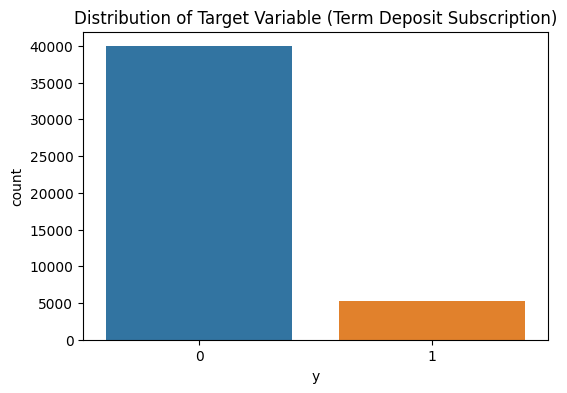

y
0    88.30152
1    11.69848
Name: proportion, dtype: float64


In [16]:
plt.figure(figsize=(6, 4))
sns.countplot(x='y', data=data)
plt.title('Distribution of Target Variable (Term Deposit Subscription)')
plt.show()

# Print percentage 
print(data['y'].value_counts(normalize=True) * 100)

### Checking correlation

For the time being we will ignore non-numeric columns when calculating the correlation matrix

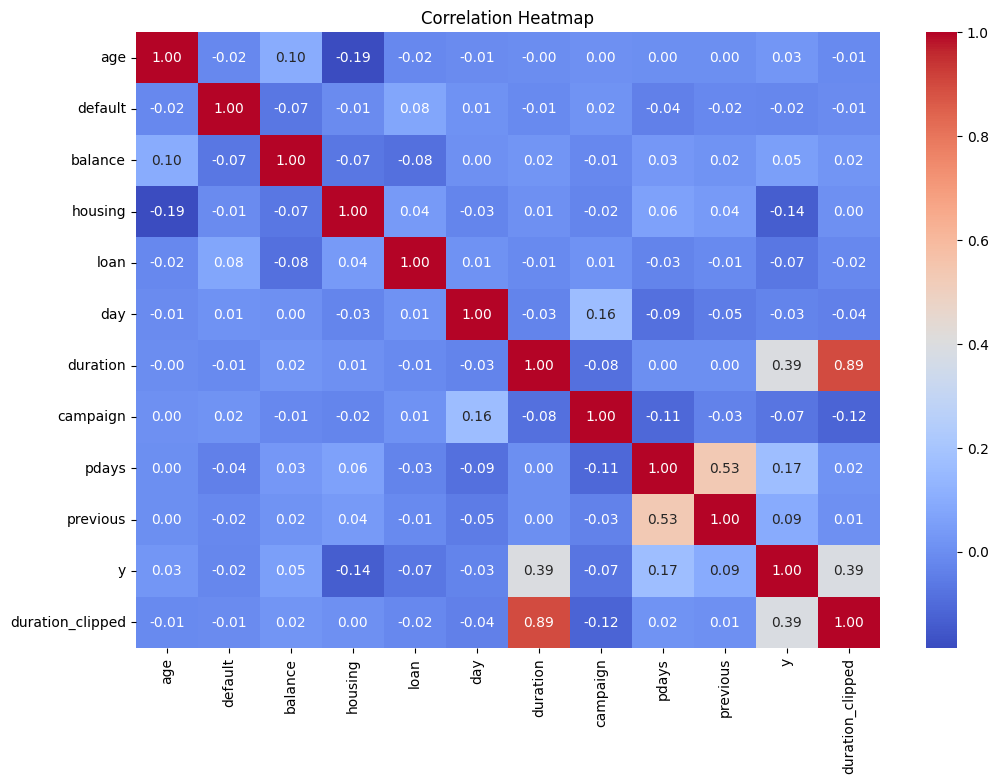

In [17]:
# Select only numeric columns from the data
numeric_data = data.select_dtypes(include=['int64', 'float64'])

# Compute the correlation matrix
corr_matrix = numeric_data.corr()

# Heatmap of correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

### Exploring each feature individualy 

Let’s look at the distribution of important numeric features like age, balance, duration_clipped and campaign

/Users/farissi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


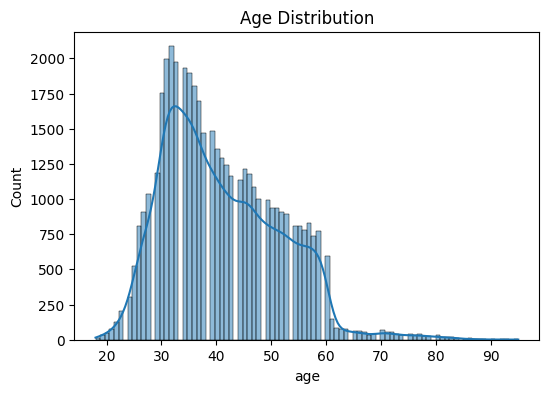

In [18]:
# Plot distribution of 'age'
plt.figure(figsize=(6, 4))
sns.histplot(data['age'], kde=True)
plt.title('Age Distribution')
plt.show()

/Users/farissi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


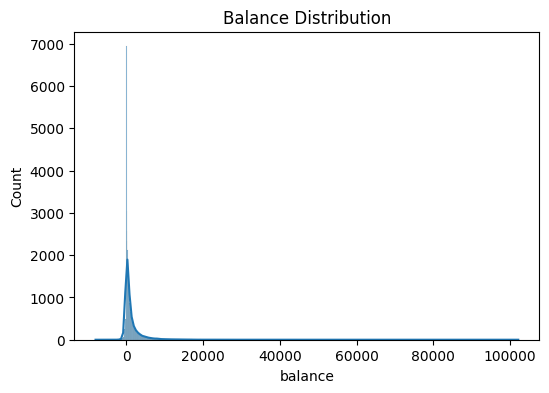

In [19]:
plt.figure(figsize=(6, 4))
sns.histplot(data['balance'], kde=True)
plt.title('Balance Distribution')
plt.show()

/Users/farissi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


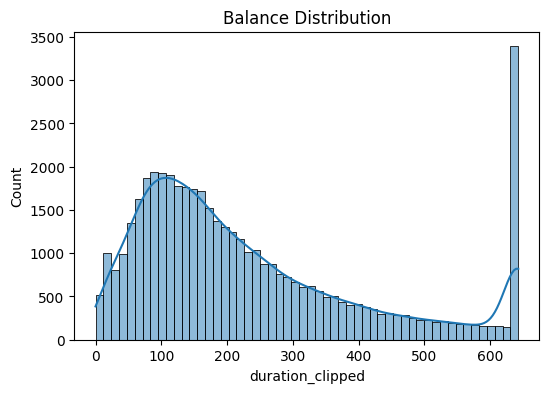

In [20]:
plt.figure(figsize=(6, 4))
sns.histplot(data['duration_clipped'], kde=True)
plt.title('Balance Distribution')
plt.show()

/Users/farissi/Library/Python/3.9/lib/python/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


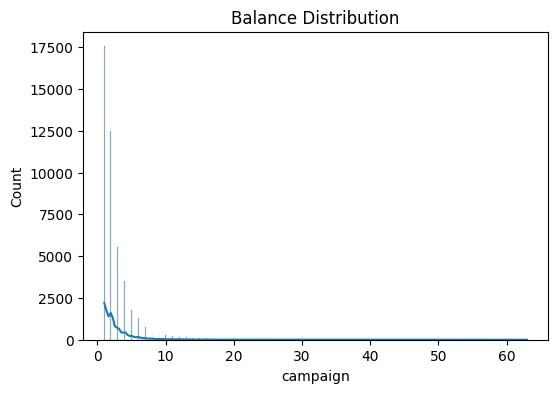

In [21]:
plt.figure(figsize=(6, 4))
sns.histplot(data['campaign'], kde=True)
plt.title('Balance Distribution')
plt.show()

## 3. Model Building and Evaluation

For this  dataset the target 'y' variable is binary (either 1 for yes or 0 for no) so the appropriate model for this case is **Logistic Regression**


Before we split data and fit it to the model we first need to apply one-hot coding to categorical columns then scale data numeric features so they can be on the same scale 


In [30]:
# ONE-HOT encoding 
data = pd.get_dummies(data, columns=['job', 'marital', 'education', 'contact', 'month', 'day', 'poutcome'], drop_first=True)



In [32]:
#scaling data only for numeric columns 
numeric_cols = ['age', 'balance', 'campaign', 'previous']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the numeric columns
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [33]:
# Defining Features X (all columns except the target y) and the target variable y
X = data.drop('y', axis=1)
y = data['y']

# training 80% and testing 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Checking the shape of the split data
print(f"Training features: {X_train.shape}, Testing features: {X_test.shape}")
print(f"Training target: {y_train.shape}, Testing target: {y_test.shape}")




Training features: (36168, 72), Testing features: (9043, 72)
Training target: (36168,), Testing target: (9043,)


In [38]:
#we build the Logistic Regression
LR = LogisticRegression(max_iter=2000)
LR.fit(X_train, y_train)



/Users/farissi/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [40]:
y_pred = LR.predict(X_test)


In [46]:

# accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 89.90%


In [47]:

# confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[7730  222]
 [ 691  400]]


In [49]:

# classification report include precision, recall and f1-score 
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.97      0.94      7952
           1       0.64      0.37      0.47      1091

    accuracy                           0.90      9043
   macro avg       0.78      0.67      0.71      9043
weighted avg       0.88      0.90      0.89      9043

